# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn
import itertools
import sklearn
from sklearn import linear_model

In [32]:
# hyperparameters
startyear=1990
coefThreshold  = 0.5

In [3]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


As we can see in the dataframe above, we have several rows (measurements) for the same target. To make the best possible analysis, we would like to use the measurements with most values for each target.

That's why we first count the number of values for each row and then filter the targets for the rows with most values.

In [4]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [5]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [6]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


See which Targets are left in our data frame.

In [9]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [10]:
# create empty dictionary
target_dfs = {}

In [11]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [12]:
# example of Target with more than one Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [13]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [14]:
frames = list(max_dfrows[target] for target in targets)

In [15]:
merged_df = pd.concat(frames, axis=0)

In [16]:
units = list(set(merged_df['Unit']))

We know that most of our Indicators are given in the unit 'percent', but we want to see here what are other units

In [17]:
units.remove('Percent')
units

['Metric Tons', 'USD', 'Constant USD']

Which and how many Indicators are expressed in other units than 'percent'?

In [18]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


### Clean up data frame

To prepare the dataframe for the actual analysis, we remove unused columns and transpose the dataframe, having years of measurements as rows and targets as columns.

In [19]:
# Drop unused columns
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

# transpose
final_t_original = final_df.T

targets = list(final_t_original.columns)

Normalize the data set to reduce any covariate shift

In [20]:
def normalize_df(df):
    return (df -df.mean())/df.std()

In [21]:
final_t = normalize_df(final_t_original)

In [22]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)

In [23]:
std_df = final_t_original.std()
mean_df = final_t_original.mean()

In [24]:
std_df['2.1']

2.424699294070642

### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the (standardized) correlation coefficient is higher than 0.9.

In [39]:
import sklearn
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [40]:
def calcCorr(df, target1, target2):
    # list of values
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
                    
    #correlation between two targets
    mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
    t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
    t2_list = list(itertools.compress(t2_list, mask))

                    
    #correlation between two targets
    pearson_r = pearsonr(t1_list, t2_list)[0]
    corrCoef = r2_score(t1_list, t2_list)
    
    return pearson_r, corrCoef

def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


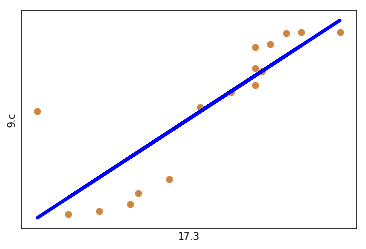

MAE: 0.37398
RMSE: 0.52717
R2: 0.704
17.3 9.c
Coefficient 0.6775768580004266
--------------------------


17.3 1.1
Coefficient 0.0
--------------------------


17.3 8.1
Coefficient -1.5028847311599307
--------------------------




/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


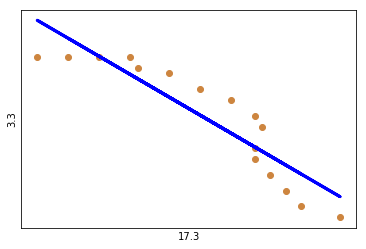

MAE: 0.36480
RMSE: 0.40741
R2: 0.823
17.3 3.3
Coefficient -2.8143347377381893
--------------------------


17.3 3.6
Coefficient -1.296350104222597
--------------------------




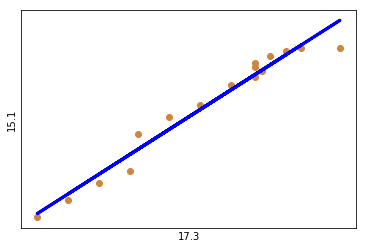

MAE: 0.14956
RMSE: 0.18861
R2: 0.963
17.3 15.1
Coefficient 0.9484962895459196
--------------------------




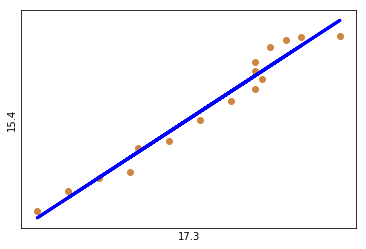

MAE: 0.16512
RMSE: 0.18415
R2: 0.963
17.3 15.4
Coefficient 0.9438191720174137
--------------------------


17.3 6.b
Coefficient 0.0
--------------------------




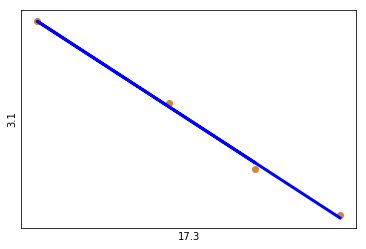

MAE: 0.03773
RMSE: 0.04524
R2: 0.997
17.3 3.1
Coefficient -1.8552661357312257
--------------------------


17.3 16.3
Coefficient -2.340841297618124
--------------------------




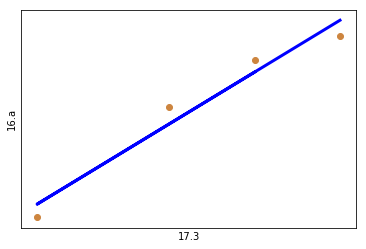

MAE: 0.18319
RMSE: 0.18509
R2: 0.957
17.3 16.a
Coefficient 0.8734962422735247
--------------------------




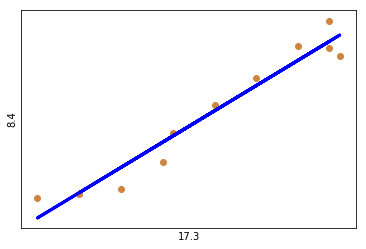

MAE: 0.19292
RMSE: 0.22492
R2: 0.944
17.3 8.4
Coefficient 0.6660389073749532
--------------------------




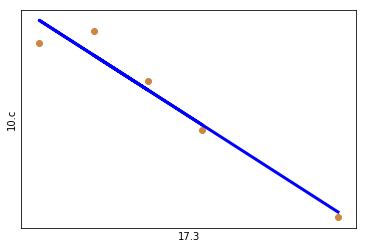

MAE: 0.17661
RMSE: 0.20953
R2: 0.945
17.3 10.c
Coefficient -20.941983499288117
--------------------------




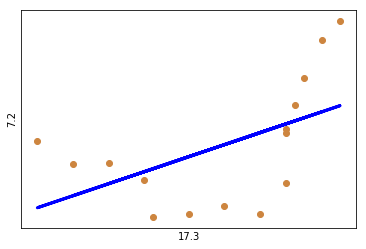

MAE: 0.70540
RMSE: 0.82393
R2: 0.273
17.3 7.2
Coefficient -0.022854526261139263
--------------------------


17.3 17.19
Coefficient -10.01954704868308
--------------------------




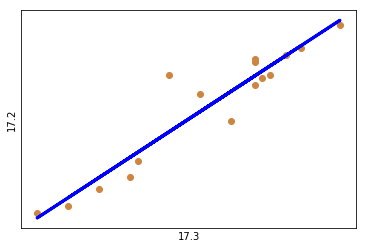

MAE: 0.21113
RMSE: 0.28990
R2: 0.896
17.3 17.2
Coefficient 0.8837188986249602
--------------------------


17.3 8.2
Coefficient -1.214759178328312
--------------------------




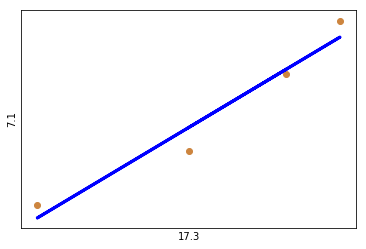

MAE: 0.17392
RMSE: 0.19128
R2: 0.951
17.3 7.1
Coefficient 0.884380580109358
--------------------------




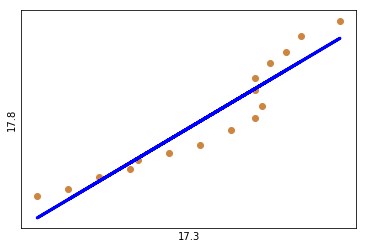

MAE: 0.27870
RMSE: 0.31967
R2: 0.891
17.3 17.8
Coefficient 0.8878572783781387
--------------------------




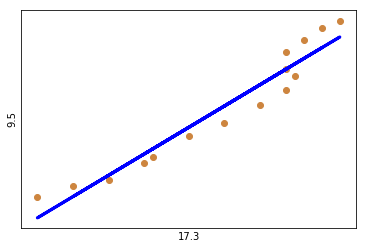

MAE: 0.22587
RMSE: 0.24919
R2: 0.933
17.3 9.5
Coefficient 0.9136612679969869
--------------------------




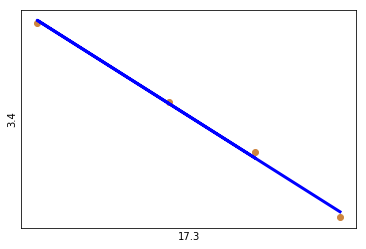

MAE: 0.04627
RMSE: 0.05138
R2: 0.996
17.3 3.4
Coefficient -1.854720434447382
--------------------------




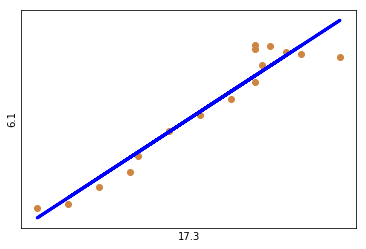

MAE: 0.20127
RMSE: 0.26570
R2: 0.925
17.3 6.1
Coefficient 0.9232224104425928
--------------------------




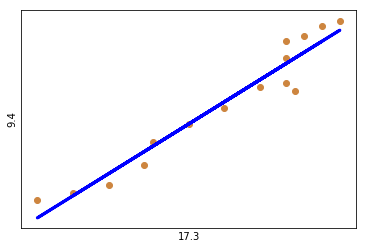

MAE: 0.19769
RMSE: 0.24166
R2: 0.937
17.3 9.4
Coefficient 0.9179768401860315
--------------------------


17.3 15.2
Coefficient -11.40790850806018
--------------------------




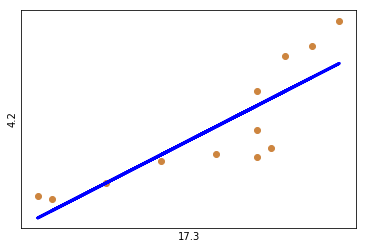

MAE: 0.43584
RMSE: 0.50755
R2: 0.719
17.3 4.2
Coefficient 0.020871261829203624
--------------------------




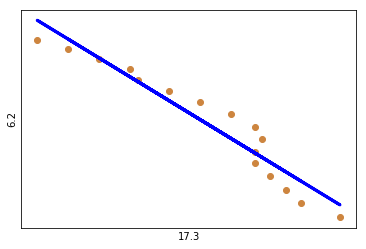

MAE: 0.23697
RMSE: 0.27408
R2: 0.920
17.3 6.2
Coefficient -2.9181973653228277
--------------------------




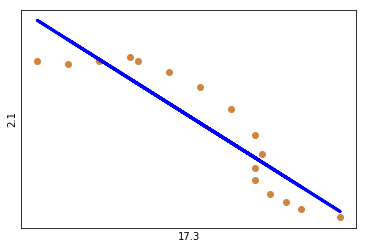

MAE: 0.24808
RMSE: 0.27505
R2: 0.828
17.3 2.1
Coefficient -2.0746100981961706
--------------------------




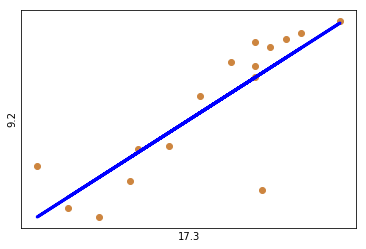

MAE: 0.36275
RMSE: 0.52981
R2: 0.686
17.3 9.2
Coefficient 0.6571148225933412
--------------------------




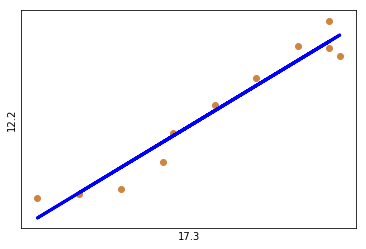

MAE: 0.19292
RMSE: 0.22492
R2: 0.944
17.3 12.2
Coefficient 0.6660389073749532
--------------------------




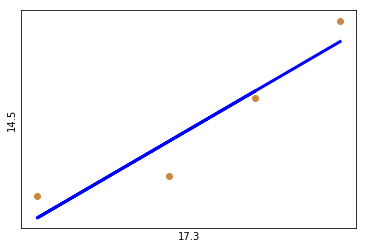

MAE: 0.24279
RMSE: 0.26900
R2: 0.887
17.3 14.5
Coefficient 0.7685663805490732
--------------------------




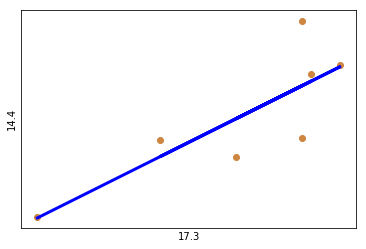

MAE: 0.32764
RMSE: 0.44599
R2: 0.669
17.3 14.4
Coefficient 0.0823807818159763
--------------------------




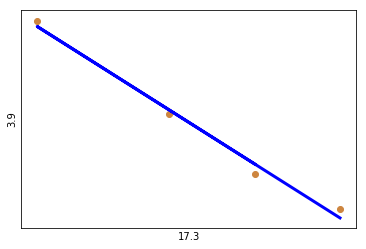

MAE: 0.08706
RMSE: 0.09338
R2: 0.988
17.3 3.9
Coefficient -1.8491087907796095
--------------------------


9.c 1.1
Coefficient 0.0
--------------------------


9.c 8.1
Coefficient -1.285012854055374
--------------------------




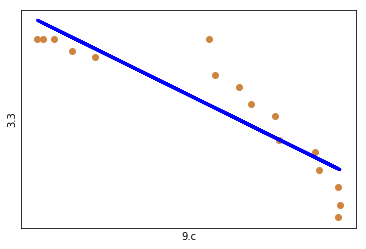

MAE: 0.35504
RMSE: 0.43922
R2: 0.794
9.c 3.3
Coefficient -2.7823907403111234
--------------------------




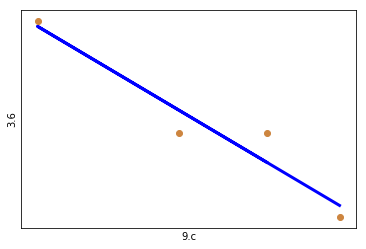

MAE: 0.21307
RMSE: 0.24317
R2: 0.921
9.c 3.6
Coefficient -3.355346829296657
--------------------------




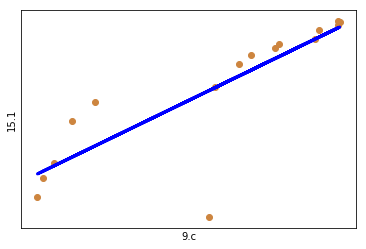

MAE: 0.29302
RMSE: 0.53846
R2: 0.695
9.c 15.1
Coefficient 0.6513311195944474
--------------------------




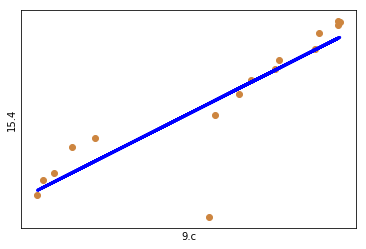

MAE: 0.25411
RMSE: 0.45910
R2: 0.767
9.c 15.4
Coefficient 0.7369812744908837
--------------------------


9.c 6.b
Coefficient 0.0
--------------------------




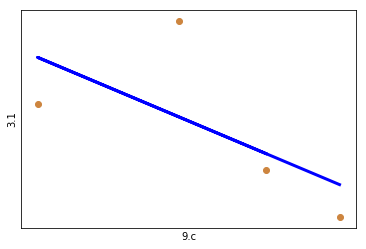

MAE: 0.56246
RMSE: 0.66183
R2: 0.416
9.c 3.1
Coefficient -2.653557447820098
--------------------------


9.c 16.3
Coefficient -1.7798281755030403
--------------------------


9.c 16.a
Coefficient -0.3595926568708181
--------------------------




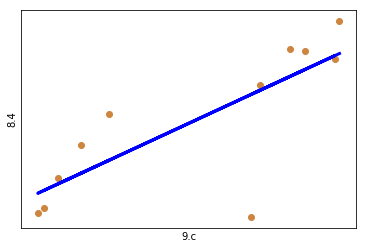

MAE: 0.40425
RMSE: 0.59127
R2: 0.615
9.c 8.4
Coefficient 0.1708427815520167
--------------------------




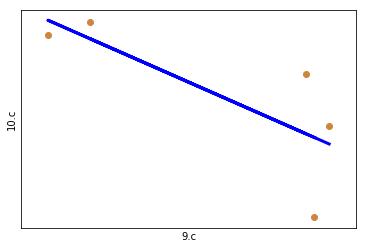

MAE: 0.47570
RMSE: 0.58288
R2: 0.575
9.c 10.c
Coefficient -220.62408611356125
--------------------------




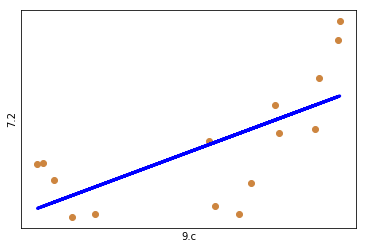

MAE: 0.60912
RMSE: 0.71061
R2: 0.459
9.c 7.2
Coefficient 0.3431385868216388
--------------------------




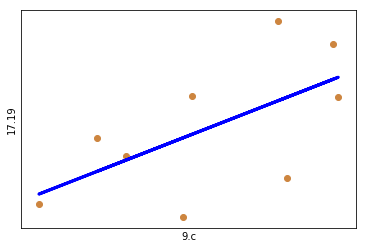

MAE: 0.61787
RMSE: 0.74480
R2: 0.376
9.c 17.19
Coefficient -6.357160104252599
--------------------------




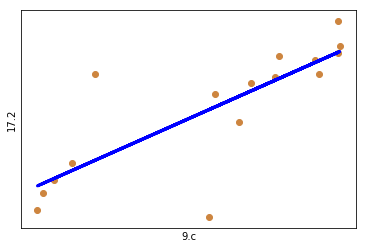

MAE: 0.32643
RMSE: 0.54146
R2: 0.637
9.c 17.2
Coefficient 0.6084072887616996
--------------------------


9.c 8.2
Coefficient -1.0676783944405086
--------------------------




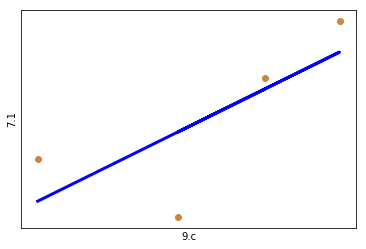

MAE: 0.49088
RMSE: 0.58106
R2: 0.550
9.c 7.1
Coefficient 0.39220170449579683
--------------------------




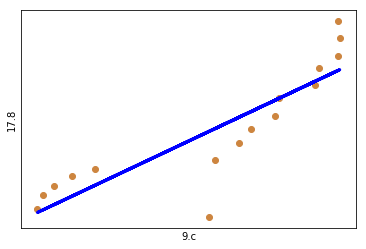

MAE: 0.35976
RMSE: 0.48147
R2: 0.753
9.c 17.8
Coefficient 0.735206291170455
--------------------------




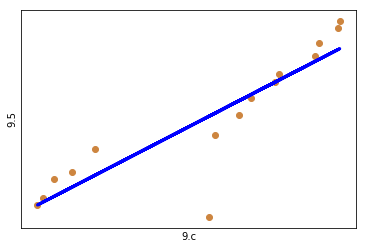

MAE: 0.28036
RMSE: 0.45148
R2: 0.782
9.c 9.5
Coefficient 0.7602101870646519
--------------------------




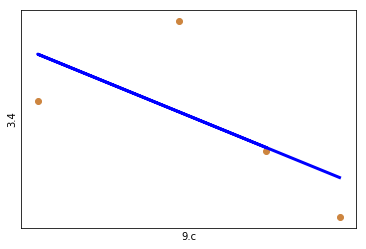

MAE: 0.54802
RMSE: 0.66312
R2: 0.414
9.c 3.4
Coefficient -2.649672794697873
--------------------------




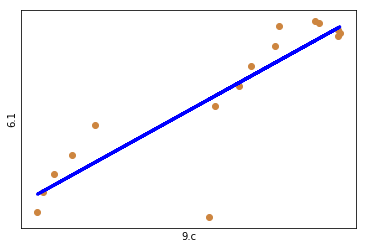

MAE: 0.28425
RMSE: 0.46728
R2: 0.767
9.c 6.1
Coefficient 0.7516714307892127
--------------------------




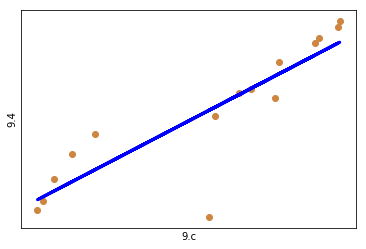

MAE: 0.30123
RMSE: 0.47172
R2: 0.762
9.c 9.4
Coefficient 0.7372091132211682
--------------------------


9.c 15.2
Coefficient -11.704752807642583
--------------------------




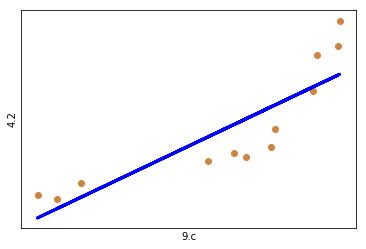

MAE: 0.43993
RMSE: 0.48925
R2: 0.739
9.c 4.2
Coefficient 0.6399837974531908
--------------------------




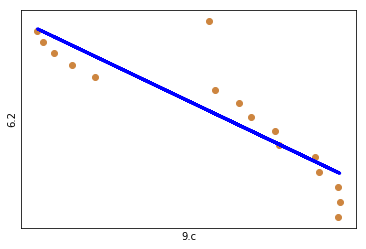

MAE: 0.33077
RMSE: 0.46661
R2: 0.768
9.c 6.2
Coefficient -2.7524362040958046
--------------------------




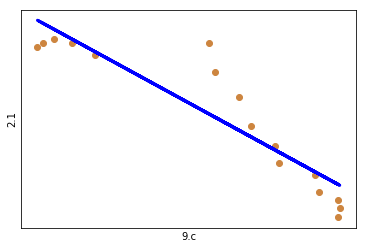

MAE: 0.20640
RMSE: 0.27130
R2: 0.833
9.c 2.1
Coefficient -2.0781012513055206
--------------------------




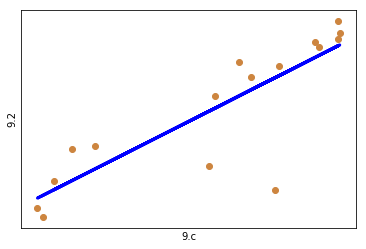

MAE: 0.35030
RMSE: 0.50453
R2: 0.715
9.c 9.2
Coefficient 0.6912549387906681
--------------------------




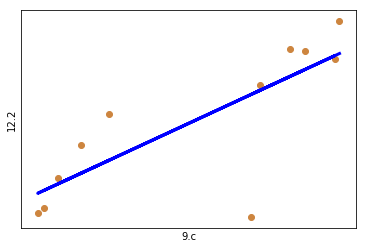

MAE: 0.40425
RMSE: 0.59127
R2: 0.615
9.c 12.2
Coefficient 0.1708427815520167
--------------------------




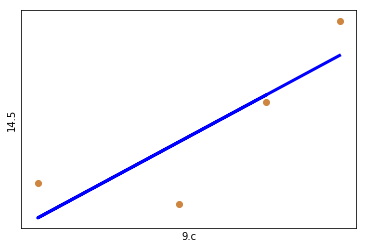

MAE: 0.38056
RMSE: 0.43831
R2: 0.700
9.c 14.5
Coefficient 0.39680007424109565
--------------------------




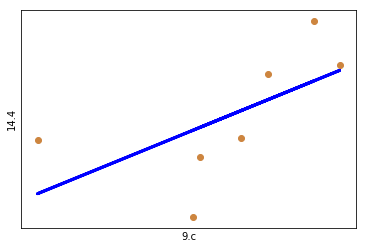

MAE: 0.52033
RMSE: 0.60966
R2: 0.381
9.c 14.4
Coefficient -0.28753505940877844
--------------------------




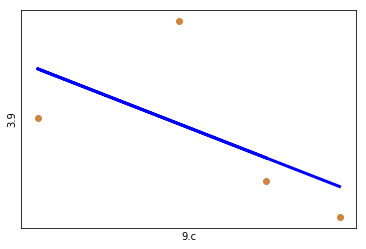

MAE: 0.59761
RMSE: 0.69871
R2: 0.349
9.c 3.9
Coefficient -2.5347048565983243
--------------------------


1.1 8.1
Coefficient 0.0
--------------------------


1.1 3.3
Coefficient 0.0
--------------------------


1.1 3.6
Coefficient 0.0
--------------------------


1.1 15.1
Coefficient 0.0
--------------------------


1.1 15.4
Coefficient 0.0
--------------------------




/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2998: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/home/felix/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2999: RuntimeWarning: Mean of empty slice.
  my = y.mean()


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [73]:
keptPairs = list()
processedPairs = list()
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}


for targetx in targets:     #loop over all targets
        
        for targety in targets:
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    p_r, coef = calcCorr(final_t_shuffled, targetx, targety)
                    
                    # filter out independant variables (coefficient close to 0, coefficient > 100)
                    if (coefThreshold < np.abs(p_r) < 1):
                            
                        keptPairs.extend([tuple((targetx, targety))])

                        if p_r > 0: edge_color = 'g'#edgecolor.append('g')
                        else: edge_color = 'r'
                                    
                        edgecolor.append(edge_color)
                        pairsAndRel[targetx, targety] = edge_color
                        
                        
                        X = final_t_shuffled[targetx].reshape(-1,1)
                        Y = final_t_shuffled[targety].reshape(-1,1)
                        
                        # apply mask to lists to filter out pairs containing any NaNs
                        mask = ~pd.isnull(X) & ~pd.isnull(Y)

                        X = X[mask].reshape(-1, 1)
                        Y = Y[mask].reshape(-1, 1)
                        
                        linreg = linear_model.LinearRegression()
                        linreg.fit(X, Y)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X)
                        
                        
                        mae, rae, rmse, r2 = compute_error(Y, y_pred)
                        
                        plt.scatter(X, Y, color='peru')
                        plt.plot(X, y_pred, color='blue', linewidth=3)

                        plt.xticks(())
                        plt.yticks(())
                        plt.xlabel(targetx)
                        plt.ylabel(targety)
                        plt.show()
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))

                    else: discardedPairs.extend([[targetx, targety]])

                    print(targetx, targety)
                    print('Coefficient', coef)
                    print('--------------------------')
                    print('\n')

#print(keptPairs)

In [46]:
print("Total number of connections found: ", len(keptPairs))
print("The following target pairs have a linear correlation:", keptPairs)

Total number of connections found:  48
The following target pairs have a linear correlation: [('17.3', '9.c'), ('17.3', '3.3'), ('17.3', '15.1'), ('17.3', '15.4'), ('17.3', '3.1'), ('17.3', '16.a'), ('17.3', '8.4'), ('17.3', '10.c'), ('17.3', '7.2'), ('17.3', '17.2'), ('17.3', '7.1'), ('17.3', '17.8'), ('17.3', '9.5'), ('17.3', '3.4'), ('17.3', '6.1'), ('17.3', '9.4'), ('17.3', '4.2'), ('17.3', '6.2'), ('17.3', '2.1'), ('17.3', '9.2'), ('17.3', '12.2'), ('17.3', '14.5'), ('17.3', '14.4'), ('17.3', '3.9'), ('9.c', '3.3'), ('9.c', '3.6'), ('9.c', '15.1'), ('9.c', '15.4'), ('9.c', '3.1'), ('9.c', '8.4'), ('9.c', '10.c'), ('9.c', '7.2'), ('9.c', '17.19'), ('9.c', '17.2'), ('9.c', '7.1'), ('9.c', '17.8'), ('9.c', '9.5'), ('9.c', '3.4'), ('9.c', '6.1'), ('9.c', '9.4'), ('9.c', '4.2'), ('9.c', '6.2'), ('9.c', '2.1'), ('9.c', '9.2'), ('9.c', '12.2'), ('9.c', '14.5'), ('9.c', '14.4'), ('9.c', '3.9')]


### Graphical Models

In [47]:
import networkx as nx

In [48]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

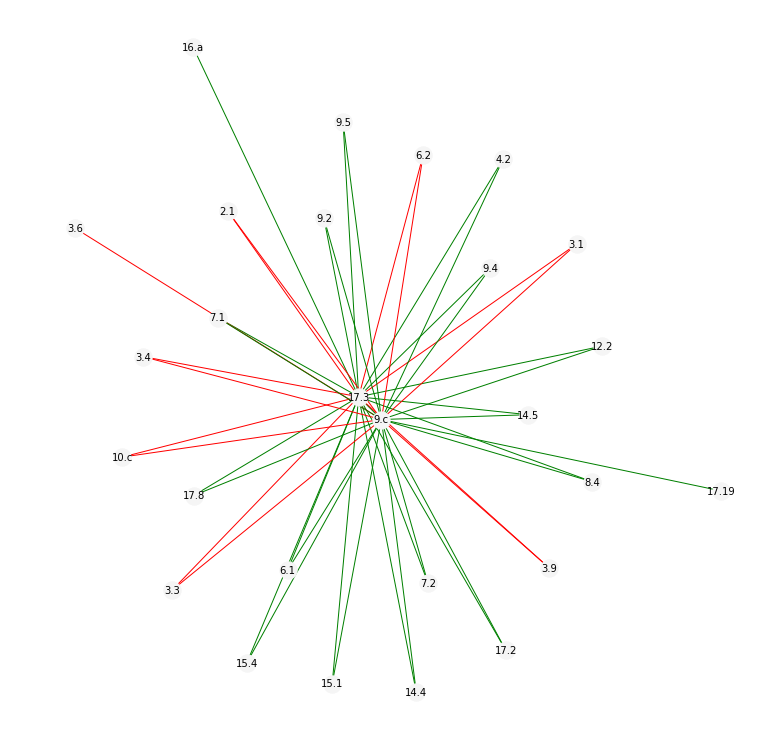

In [49]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(10,10)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph and are plotted closer together. There are also some targets that are only connected to one other target.

Positive interconnections are indicated by a green, negative by a red edge.

In [50]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
#overlay.show()
#overlay.save("final.png")

To extract the cliques (complete subgraphs of the graph) that already are visible in the graph above, we use networkx' inbuilt function find_cliques(G).

We would like to make our imputations first on one of these cliques, actually on one that has the most members.


In [51]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['9.c', '17.3', '17.2'],
 ['9.c', '17.3', '14.5'],
 ['9.c', '17.3', '7.1'],
 ['9.c', '17.3', '3.3'],
 ['9.c', '17.3', '17.8'],
 ['9.c', '17.3', '9.5'],
 ['9.c', '17.3', '3.4'],
 ['9.c', '17.3', '9.4'],
 ['9.c', '17.3', '6.1'],
 ['9.c', '17.3', '7.2'],
 ['9.c', '17.3', '4.2'],
 ['9.c', '17.3', '6.2'],
 ['9.c', '17.3', '2.1'],
 ['9.c', '17.3', '15.1'],
 ['9.c', '17.3', '15.4'],
 ['9.c', '17.3', '9.2'],
 ['9.c', '17.3', '3.1'],
 ['9.c', '17.3', '12.2'],
 ['9.c', '17.3', '8.4'],
 ['9.c', '17.3', '10.c'],
 ['9.c', '17.3', '14.4'],
 ['9.c', '17.3', '3.9'],
 ['9.c', '3.6'],
 ['9.c', '17.19'],
 ['16.a', '17.3']]

In [52]:
# finding clique containing most nodes
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [53]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


In [54]:
cliqueGraph = complete_graph_from_list(max_clique)

In [55]:
cliqueGraph_edges = list(cliqueGraph.edges)
pairsDictListKeys = list(pairsAndRel.keys())

In [56]:
clique_e_color = []
for edge in cliqueGraph_edges:
    if edge in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge])
    elif edge[::-1] in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge[::-1]])

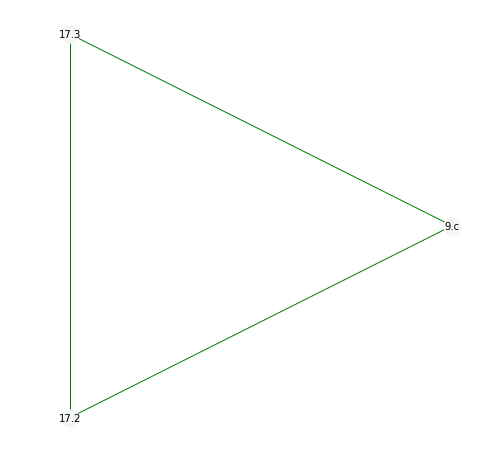

In [57]:
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, edge_color=clique_e_color, node_color='whitesmoke')
plt.show()

In [58]:
print('Our max clique consists of the following targets: ', cliqueGraph.nodes)

Our max clique consists of the following targets:  ['9.c', '17.3', '17.2']


# 2. Build temporal model to infer missing observations - observing covariance in the residuals

We have a temporal model with missing observations as NaNs, and want to infer them according to their correlated targets and their own time series development. Therefore, we design a linear dynamical system with inputs, including an autoregressive model of order 2.

## Define STAN model

From now on, we can actually forget all information we've gotten so far. With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets correlated?**

**2. What are expectable values for missing observations (imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

    multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}


**Note** that we want to make the missing observation dependent on two previous observations. This is equivalent to define an autoregressive model of order 2.

<img src="pgm.png">

In [59]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs1];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis1];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs2];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis2];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}

transformed data {
    int<lower = 0> T = N_obs1 + N_mis1;  // length of the time-series
}

parameters {
    vector[2] beta[2];            // state transition coefficients 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;     // uncertainty in the latent space
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}

transformed parameters {
    real y1[T];
    real y2[T];
    matrix[2,2] L_sigma;
    y1[ix_obs1] = y_obs1;
    y1[ix_mis1] = y_mis1;
    y2[ix_obs2] = y_obs2;
    y2[ix_mis2] = y_mis2;
}

model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(1);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,5);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first latent state
    z[2,:] ~ normal(0,1);           // prior on second latent state
    
    for(t in 3:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-2):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-2):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

### What targets are in our clique?

We will work for the rest of the notebook with this single clique.

In [60]:
clique_nodes = list(cliqueGraph.nodes)
clique_nodes

['9.c', '17.3', '17.2']

In [61]:
clique_df_t = final_t[clique_nodes]

In [62]:
clique_df_t = clique_df_t[clique_df_t.index > str(startyear)]

In [63]:
g1_nodes = list(G1.nodes)
g1_df_t = final_t[g1_nodes]
g1_df_t = g1_df_t[g1_df_t.index > str(startyear)]

## What is observed, what is missing?

- N_obs: Number of observed values (length of loc array)
- N_mis: Number of missing values (length of loc array)
- ix_obs: indices of observed values
- ix_mis: indices of missing values
- y_obs: observed values

In [64]:
# prepare data for STAN model
def prepareInputData(df, target1, target2):
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
    
    ix_obs1 = np.where(~np.isnan(t1_list))[0]
    ix_obs2 = np.where(~np.isnan(t2_list))[0]
    
    ix_mis1 = np.where(np.isnan(t1_list))[0]
    ix_mis2 = np.where(np.isnan(t2_list))[0]
    
    y_obs1 = [t1_list[index] for index in ix_obs1]
    y_obs2 = [t2_list[index] for index in ix_obs2]
    
    N_obs1 = len(ix_obs1)
    N_obs2 = len(ix_obs2)
    
    N_mis1 = len(ix_mis1)
    N_mis2 = len(ix_mis2)
    
    data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
            'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
            'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}
    
    return data

In [65]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c2c8db35d3d6b106a2010ff56a7e73b8 NOW.


CPU times: user 1.3 s, sys: 72 ms, total: 1.38 s
Wall time: 1min 40s


### How we find the highest correlated pairs
We use here Pearson's r as a correlation coefficient what returns us *only* the pairs of random variables which are highest correlated in a linear manner. But, the world is not linear; so, we could have also used [this](http://old.econ.ucdavis.edu/faculty/cameron/research/je97preprint.pdf) correlation coefficient.

To find out which pairs would give the most cartain results after inference, we want to find the pairs that have the highest correlation between each other (lowest uncertainty in prediction). This is why we first calculate the correlation coefficient and choose the pairs that give the highest correlation coefficients.

In [72]:
bestCorrPairs = []
corrCoefs = []
for x in list(G1.nodes):
    bestCorrCoef = 0
    targetx = x
    t_y = []
    for p in keptPairs:
        #if p in processedPairs: continue
        if targetx in p:
            if p[0]!=targetx: t_y.append(p[0])
            #if (p[0]!=targetx and p not in processedPairs): t_y.append(p[0])
            else: t_y.append(p[1])
    for targety in t_y:
        corr, _ = calcCorr(final_t,targetx, targety)
        if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
            bestCorrCoef = corr
            bestPair = tuple([targetx, targety])

    bestCorrPairs.append(bestPair)
    corrCoefs.append(bestCorrCoef)

for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])

('17.3', '3.1') :  -0.9986345477475923
('9.c', '3.6') :  -0.9597680047136002
('3.3', '17.3') :  -0.9071673688690943
('15.1', '17.3') :  0.9810874111013809
('15.4', '17.3') :  0.9810799411784373
('3.1', '17.3') :  -0.9986345477475923
('16.a', '17.3') :  0.9782550867281942
('8.4', '17.3') :  0.9717775401027658
('10.c', '17.3') :  -0.9721724578938964
('7.2', '9.c') :  0.6774739156977707
('17.2', '17.3') :  0.9466013661683574
('7.1', '17.3') :  0.9753041662914969
('17.8', '17.3') :  0.9439286391890692
('9.5', '17.3') :  0.9661632648000364
('3.4', '17.3') :  -0.9982388300390304
('6.1', '17.3') :  0.9616112052212962
('9.4', '17.3') :  0.9682092579151956
('4.2', '9.c') :  0.8595787820653492
('6.2', '17.3') :  -0.9590986826614143
('2.1', '9.c') :  -0.9126994567627709
('9.2', '9.c') :  0.8455682975486154
('12.2', '17.3') :  0.9717775401027658
('14.5', '17.3') :  0.9418917076051908
('14.4', '17.3') :  0.8176452048262536
('3.9', '17.3') :  -0.9941695217210463
('3.6', '9.c') :  -0.9597680047136002

As one can see, sometimes the reversed pair is also the best correlation pair for one node. As we still only want to process these pairs once, we create an array of distinct pairs from the bestCorrPairs array.

In [69]:
corrPairs = []
for t in bestCorrPairs:
    if t[::-1] not in corrPairs: corrPairs.append(t)
print(corrPairs)
print(len(corrPairs))

[('17.3', '3.1'), ('9.c', '3.6'), ('3.3', '17.3'), ('15.1', '17.3'), ('15.4', '17.3'), ('16.a', '17.3'), ('8.4', '17.3'), ('10.c', '17.3'), ('7.2', '9.c'), ('17.2', '17.3'), ('7.1', '17.3'), ('17.8', '17.3'), ('9.5', '17.3'), ('3.4', '17.3'), ('6.1', '17.3'), ('9.4', '17.3'), ('4.2', '9.c'), ('6.2', '17.3'), ('2.1', '9.c'), ('9.2', '9.c'), ('12.2', '17.3'), ('14.5', '17.3'), ('14.4', '17.3'), ('3.9', '17.3'), ('17.19', '9.c')]
25


We calculate the covariance matrix Omega for each possible connection

In [ ]:
for pair in processedPairs:
    if len(pair) > 1:
        targetx = pair[0]
        targety = pair[1]

        # prepare input data
        inData = prepareInputData(final_t, targetx, targety)
        print(pair)

        # run inference using MCMC sampling
        fit = sm.sampling(data=inData, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
        
        samples = fit.extract(permuted=True)
        
        print(samples['Omega'][1,0][1])
        print('-----')

('17.3', '9.c')


/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [90]:
print(samples['Omega'][1,0][1])

0.3300860095291784


In [ ]:
connections = []
for pair in omegaList:
    if pair in keptPairs: connections.append(pair)
        
print('Number of pairs that have a causal and temporal relationship: ' len(connections))
print(connections)

In [81]:
type(fit)

stanfit4anon_model_c2c8db35d3d6b106a2010ff56a7e73b8_1077160484483741225.StanFit4Model

In [ ]:
for pair in processedPairs:
    targetx = pair[0]
    targety = pair[1]

    # prepare input data
    inData = prepareInputData(final_t, targetx, targety)
    print(pair)

    # run inference using MCMC sampling
    fit = sm.sampling(data=inData, iter=1000, chains=4, algorithm="NUTS", seed=42, verbose=True)
    print(fit)
    
    # what do we actually want to show? sigma and tau are performance measurements.
    fit.plot(["tau","lp__"]) # take vars from temporal model
    plt.show()

    samples = fit.extract(permuted=True)
    
    # get values for plots
    # convert indices back to year values
    ix_mis1 = inData['ix_mis1']+startyear
    ix_mis2 = inData['ix_mis2']+startyear
    ix_obs1 = inData['ix_obs1']+startyear
    ix_obs2 = inData['ix_obs2']+startyear
    
    # extract imputed and known values and renormalize them
    y_mis1 = samples['y_mis1'].mean(axis=0) * std_df[targetx] + mean_df[targetx]
    y_mis2 = samples['y_mis2'].mean(axis=0) * std_df[targety] + mean_df[targety]
    y_obs1 = np.array(inData['y_obs1']) * std_df[targetx] + mean_df[targetx]
    y_obs2 = np.array(inData['y_obs2']) * std_df[targety] + mean_df[targety]
    
    # define title and labels from original dataframe
    y1_df = merged_df[merged_df['Target']==pair[0]]
    y2_df = merged_df[merged_df['Target']==pair[1]]
    y1_title = 'Target '+pair[0]+'\n'+str(y1_df['Indicator Description'].values).replace('[','').replace(']','')
    y1_label = str(y1_df['Unit'].values).replace('[','').replace(']','')
    y2_title = 'Target '+pair[0]+'\n'+str(y2_df['Indicator Description'].values).replace('[','').replace(']','')
    y2_label = str(y2_df['Unit'].values).replace('[','').replace(']','')
    
    # plot with imputed values of target 1
    plt.plot(ix_obs1, y_obs1, "bo")
    plt.plot(ix_mis1, y_mis1, "bx")
    plt.title(y1_title)
    plt.legend(["observed values","imputed values"])
    plt.xlabel('year')
    plt.ylabel(y1_label)
    plt.show()
    
    # plot with imputed values of target 2
    plt.plot(ix_obs2, y_obs2, "bo")
    plt.plot(ix_mis2, y_mis2, "bx")
    plt.title(y2_title)
    plt.legend(["observed values", "imputed values"])
    plt.xlabel('year')
    plt.ylabel(y2_label)
    plt.show()

## Conclusion
- We were able to prove that there are strong linear correlations (correlation coefficient higher than 0.98) between some targets.
- Some dependencies might still remain undiscovered which could be identified by a correlation different from a linear one, e.g. exponential
- We have to be critical about the imputed values in the years where data for both targets are missing (only dependant on the prior), but can be rather confident on imputed values that have an observation in the correlated target.
- Some of the predictions for y can only be given low confidence as the number of effective values used for this prediction is very low.
- We have a dependency on the time series overally, but considering each time step separately, we don't have very good correlations.
- Causality!

## Open questions: What we haven't understood so far

- Omega[1,0] is a value of Omega that gives us the correlation between Target 1 and 2. What kind of correlation measure is it? How can it be different/lower from our previously found Pearson r?

 Omega explains the residuals,  i.e. taking away the time series dependency, what is left of the correlation?
 Correlation of deviations in the processes. 
 Causation can occur without correlation

## Prospect: What we can do next
- use inferred values and/or identified relations to make predictions for the future based on assumptions of the development of one indicator
- find "plan of action" to improve one target/reach one target